# Neural Network

## Data Extraction + W2V

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
def load_data(filepath):
    data = []

    with open(filepath, "r") as file:
        for line in file:
            parts = line.strip().split(maxsplit=1)
            data.append((int(parts[0]), parts[1]))

    return data

In [3]:
from gensim.models import Word2Vec

def greek_W2V(dim, quotes, window, min_count, workers):
    '''
    Create Word2Vec
    '''
    w2v_greek = Word2Vec(
        sentences=quotes,
        vector_size=dim,
        window=window,
        min_count=min_count,
        workers=workers
    )

    w2v_greek.save("greek_word2vec.model")
    return w2v_greek

## Dubia and Testset Generation

In [4]:
def dubia_testset(data, chunk_size, w2v_model):
    """
    Create Dubia Dataset Test Set
    """
    chunks = []
    embeddings = []

    for label, text in data:
        if label != -1:
            continue

        # Split text into words and calculate number of chunks
        words = text.split()
        num_chunks = len(words) - chunk_size + 1
        if num_chunks <= 0:
            continue

        # Generate sliding window chunks
        text_chunks = [
            " ".join(words[i:i + chunk_size])
            for i in range(1, num_chunks)
        ]

        # Generate embeddings for each chunk
        chunk_embeddings = [flatten_chunk(chunk, w2v_model) for chunk in text_chunks]
        
        # Append results
        chunks.extend(text_chunks)
        embeddings.extend(chunk_embeddings)

    return chunks, np.array(embeddings)

In [5]:
def single_text_testset(data, chunk_size, w2v_model, text_name):
    """
    Prepares a test set for a single text in the dubia dataset by text name.
    """
    chunks = []
    embeddings = []

    for label, text in data:
        if label != -1:
            continue

        words = text.split()
        if words[0] == text_name:
            
            # Remove the text name and first word (number) from the text body
            text_body = " ".join(words[1:])
    
            # Generate sliding window chunks
            num_chunks = len(text_body.split()) - chunk_size + 1
            if num_chunks <= 0:
                continue
    
            text_chunks = [
                " ".join(text_body.split()[i:i + chunk_size])
                for i in range(num_chunks)
            ]
    
            # Generate embeddings for each chunk
            chunk_embeddings = [flatten_chunk(chunk, w2v_model) for chunk in text_chunks]
    
            # Append results
            chunks.extend(text_chunks)
            embeddings.extend(chunk_embeddings)
    
            embeddings = np.array(embeddings)
            return chunks, embeddings

    return chunks, np.array(embeddings)  # Fallback in case no matching text is found

In [6]:
def all_texts_testset(data, chunk_size, w2v_model):
    """
    Prepares a test set for all dubia texts, calculates predictions, and outputs mean scores.
    """
    results = {}

    for label, text in data:
        words = text.split()
        text_name = words[0]
        text_body = " ".join(words[1:])

        # Generate sliding window chunks
        num_chunks = len(text_body.split()) - chunk_size + 1
        if num_chunks <= 0:
            continue  # Skip if the text is shorter than the chunk size

        text_chunks = [
            " ".join(text_body.split()[i:i + chunk_size])
            for i in range(num_chunks)
        ]

        # Generate embeddings for each chunk
        chunk_embeddings = [flatten_chunk(chunk, w2v_model) for chunk in text_chunks]

        # Convert embeddings to NumPy array
        X_test = np.array(chunk_embeddings)

        # Get predictions for the embeddings
        predictions = model.predict(X_test)

        # Calculate the mean prediction
        mean_score = np.mean(predictions)
        results[text_name] = mean_score

    return results

## Basic NN with mean pooling of word embeddings

In [7]:
def flatten_chunk(chunk, w2v_model):
    """
    Converts a chunk of text into a fixed-size vector using mean pooling.
    """
    words = chunk.split()
    embedding_dim = w2v_model.vector_size
    
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    
    if embeddings:
        flattened_embedding = np.mean(embeddings, axis=0)
    else:
        flattened_embedding = np.zeros(embedding_dim)
    
    return flattened_embedding

In [8]:
from sklearn.model_selection import train_test_split

def prepare_dataset(data, w2v_model, chunk_size, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Processes text data into sliding window chunks with embeddings,
    splits the data into training, validation, and test sets, and randomizes it.
    """
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for label, text in data:
        words = text.split()
        num_chunks = len(words) - chunk_size + 1
        if num_chunks <= 0:
            continue

        # Generate sliding window chunks
        chunks = [
            " ".join(words[i:i + chunk_size])
            for i in range(1, num_chunks)
        ]

        # Generate embeddings for each chunk
        embeddings = [flatten_chunk(chunk, w2v_model) for chunk in chunks]
        labels = [label] * len(embeddings)

        # Split into train/val/test sets
        X_temp, X_test_temp, y_temp, y_test_temp = train_test_split(
            embeddings, labels, test_size=test_ratio, random_state=42
        )
        X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(
            X_temp, y_temp, test_size=val_ratio / (train_ratio + val_ratio), random_state=42
        )

        # Append to the main dataset
        X_train.extend(X_train_temp)
        y_train.extend(y_train_temp)
        X_val.extend(X_val_temp)
        y_val.extend(y_val_temp)
        X_test.extend(X_test_temp)
        y_test.extend(y_test_temp)

    # Shuffle each dataset
    train_data = list(zip(X_train, y_train))
    val_data = list(zip(X_val, y_val))
    test_data = list(zip(X_test, y_test))

    np.random.shuffle(train_data)
    np.random.shuffle(val_data)
    np.random.shuffle(test_data)

    # Unpack shuffled data
    X_train, y_train = zip(*train_data)
    X_val, y_val = zip(*val_data)
    X_test, y_test = zip(*test_data)

    return (
        np.array(X_train), np.array(y_train),
        np.array(X_val), np.array(y_val),
        np.array(X_test), np.array(y_test)
    )

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_nn(input_dim):
    """
    Creates a simple feedforward neural network with input dimension specified.
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Bsic NN Model Implementation

In [108]:
chunk_size = 200

In [92]:
tabs = {}

In [12]:
data_combined = load_data("./data_clean/combined.txt")
data_dubia = load_data("./data_clean/dubia.txt")

chunk_size = 25
dim = 100
# chunks = []
# for label, text in data_combined:
#     words = text.split()
#     for i in range(0, len(words) - chunk_size + 1):
#         chunk = ' '.join(words[i:i + chunk_size])
#         chunks.append((label, chunk))

# chunks_combined = [chunk.split() for _, chunk in chunks]
# dim = 100
# window = 5
# min_count = 1
# workers = 4
# w2v_model = greek_W2V(dim, chunks_combined, window, min_count, workers)
w2v_model = Word2Vec.load("greek_word2vec.model")

In [109]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(data_combined, w2v_model, chunk_size, 0.8, 0.1, 0.1)

import pickle

# Save datasets to a pickle file
with open(f"nn_datasets_{chunk_size}.pkl", "wb") as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

In [110]:
with open(f"nn_datasets_{chunk_size}.pkl", "rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

In [111]:
input_dim = X_train.shape[1]
model = create_nn(input_dim)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.8f}")

Epoch 1/10
25136/25136 [==============================] - 15s 606us/step - loss: 0.0891 - accuracy: 0.9667 - val_loss: 0.0305 - val_accuracy: 0.9894
Epoch 2/10
25136/25136 [==============================] - 16s 619us/step - loss: 0.0671 - accuracy: 0.9756 - val_loss: 0.0217 - val_accuracy: 0.9926
Epoch 3/10
25136/25136 [==============================] - 16s 621us/step - loss: 0.0610 - accuracy: 0.9776 - val_loss: 0.0248 - val_accuracy: 0.9930
Epoch 4/10
25136/25136 [==============================] - 16s 622us/step - loss: 0.0590 - accuracy: 0.9784 - val_loss: 0.0173 - val_accuracy: 0.9948
Epoch 5/10
25136/25136 [==============================] - 16s 624us/step - loss: 0.0556 - accuracy: 0.9800 - val_loss: 0.0168 - val_accuracy: 0.9956
Epoch 6/10
25136/25136 [==============================] - 16s 622us/step - loss: 0.0545 - accuracy: 0.9804 - val_loss: 0.0286 - val_accuracy: 0.9896
Epoch 7/10
25136/25136 [==============================] - 16s 633us/step - loss: 0.0542 - accuracy: 0.9805

In [112]:
model.save_weights(f"nn_model_weights_{chunk_size}.h5")

In [36]:
model = create_nn(input_dim)
model.load_weights(f"nn_model_weights_{chunk_size}.h5")

In [113]:
results = all_texts_testset(data_dubia, chunk_size, w2v_model)

# Print the mean scores for each text
print("\nMean Predictions for Dubia Texts:")
for text_name, mean_score in results.items():
    if mean_score is not None:
        print(f"{text_name}: {mean_score:.4f}")
    else:
        print(f"{text_name}: No valid chunks")

43/43 [==============================] - 0s 297us/step

Mean Predictions for Dubia Texts:
Minos: 0.9811
Theages: 0.9984
Lovers: 0.9981
Letters: 0.9456
Alcibiades1: 0.9840
Alcibiades2: 0.9273
Definitions: 0.0004
Hipparchus: 0.9300
Epinomis: 0.9913
Cleitophon: 0.9985


In [114]:
results["Test Set"] = test_accuracy
tabs[chunk_size] = results

In [115]:
print(tabs)

{50: {'Minos': 0.9037467, 'Theages': 0.95138687, 'Lovers': 0.9669575, 'Letters': 0.81322163, 'Alcibiades1': 0.9460928, 'Alcibiades2': 0.87739533, 'Definitions': 0.22079529, 'Hipparchus': 0.86184067, 'Epinomis': 0.85806566, 'Cleitophon': 0.89053386, 'Test Set': 0.9578686356544495}, 25: {'Minos': 0.82250017, 'Theages': 0.88815504, 'Lovers': 0.87979305, 'Letters': 0.7393676, 'Alcibiades1': 0.8885729, 'Alcibiades2': 0.802056, 'Definitions': 0.31760162, 'Hipparchus': 0.8285081, 'Epinomis': 0.7590754, 'Cleitophon': 0.81606627, 'Test Set': 0.913121223449707}, 100: {'Minos': 0.9363014, 'Theages': 0.98487705, 'Lovers': 0.9953097, 'Letters': 0.8490637, 'Alcibiades1': 0.9622661, 'Alcibiades2': 0.9188408, 'Definitions': 0.13273369, 'Hipparchus': 0.8922686, 'Epinomis': 0.87343794, 'Cleitophon': 0.9406886, 'Test Set': 0.9852348566055298}, 200: {'Minos': 0.98105466, 'Theages': 0.9984383, 'Lovers': 0.99805754, 'Letters': 0.9456431, 'Alcibiades1': 0.9840474, 'Alcibiades2': 0.9273165, 'Definitions': 0.0

In [117]:
with open("basic_nn_results.pkl", "wb") as file:
    pickle.dump(tabs, file)

In [118]:
with open("basic_nn_results.pkl", "rb") as file:
    tabs = pickle.load(file)

In [125]:
sorted_data = sorted(tabs.items(), key=lambda x: x[0])

df = pd.DataFrame([
    {"Chunk Size": chunk_size, **text_scores}
    for chunk_size, text_scores in sorted_data
])

df.set_index("Chunk Size", inplace=True)
print(df)

               Minos   Theages    Lovers   Letters  Alcibiades1  Alcibiades2  \
Chunk Size                                                                     
25          0.822500  0.888155  0.879793  0.739368     0.888573     0.802056   
50          0.903747  0.951387  0.966958  0.813222     0.946093     0.877395   
100         0.936301  0.984877  0.995310  0.849064     0.962266     0.918841   
200         0.981055  0.998438  0.998058  0.945643     0.984047     0.927316   

            Definitions  Hipparchus  Epinomis  Cleitophon  Test Set  
Chunk Size                                                           
25             0.317602    0.828508  0.759075    0.816066  0.913121  
50             0.220795    0.861841  0.858066    0.890534  0.957869  
100            0.132734    0.892269  0.873438    0.940689  0.985235  
200            0.000410    0.930046  0.991314    0.998488  0.993508  


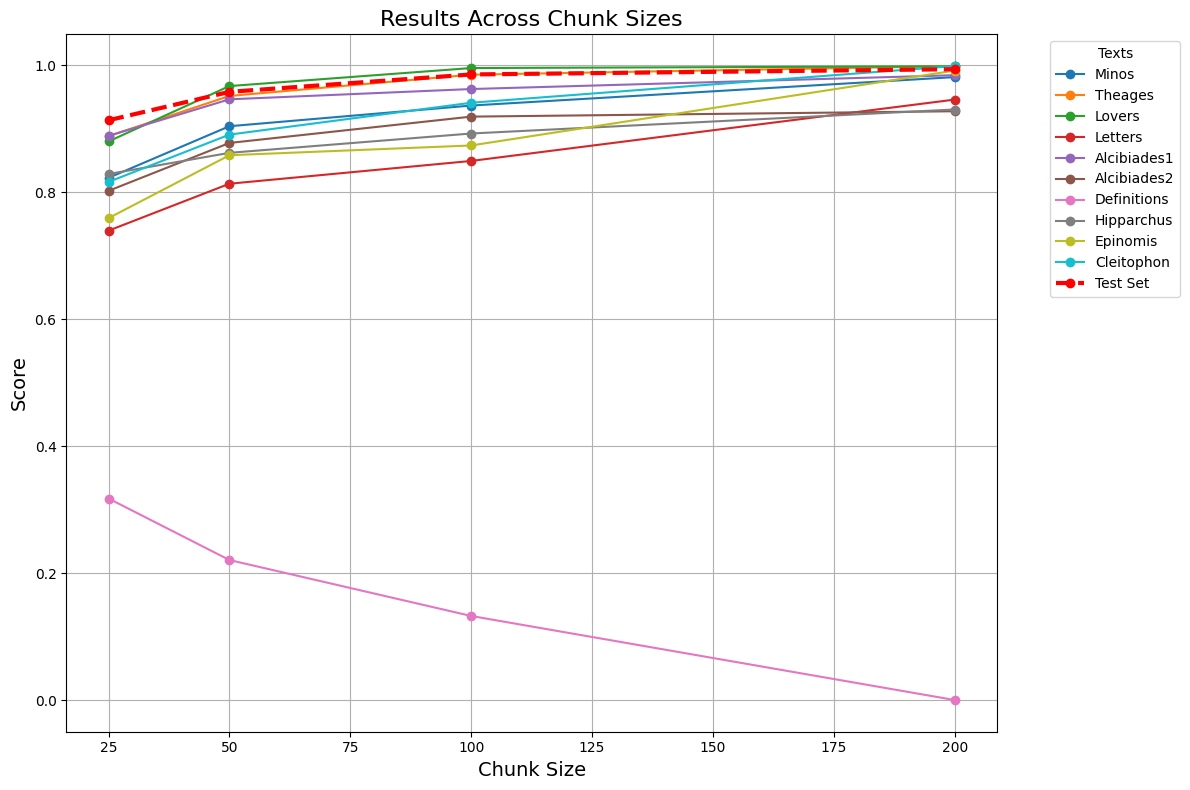

In [130]:
# Convert dictionary to sorted list for easier processing
sorted_data = sorted(tabs.items(), key=lambda x: x[0])
chunk_sizes = [item[0] for item in sorted_data]
text_scores = {text: [] for text in next(iter(tabs.values())).keys()}

# Populate scores for each text
for _, scores in sorted_data:
    for text, score in scores.items():
        text_scores[text].append(score)

# Plot the results
plt.figure(figsize=(12, 8))

for text, scores in text_scores.items():
    if text == "Test Set":
        plt.plot(chunk_sizes, scores, marker='o', label=text, linewidth=3, linestyle='--', color='red')  # Bold red dashed line
    else:
        plt.plot(chunk_sizes, scores, marker='o', label=text)

plt.title("Results Across Chunk Sizes", fontsize=16)
plt.xlabel("Chunk Size", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(title="Texts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## RNN LSTM -> NN Model

In [132]:
from sklearn.model_selection import train_test_split

def prepare_lstm_datasets(data, chunk_size, w2v_model, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Prepares datasets for an LSTM model by processing text into sequences of embeddings and splitting into train/val/test.
    """
    X = []
    y = []

    for label, text in data:
        words = text.split()
        num_chunks = len(words) - chunk_size + 1
        if num_chunks <= 0:
            continue

        # Generate sliding window chunks
        chunks = [
            words[i:i + chunk_size]
            for i in range(1, num_chunks)
        ]

        # Convert each chunk into a sequence of embeddings
        for chunk in chunks:
            embeddings = [
                w2v_model.wv[word] if word in w2v_model.wv else np.zeros(w2v_model.vector_size)
                for word in chunk
            ]
            X.append(embeddings)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split into train, val, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_ratio + test_ratio), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [133]:
from random import sample

def lstm_datasets_percentage(data, chunk_size, w2v_model, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, sample_ratio=0.1):
    """
    Prepares datasets for an LSTM model by processing text into sequences of embeddings and splitting into train/val/test.
    Samples a percentage of chunks from each text to reduce dataset size.
    """
    X = []
    y = []

    for label, text in data:
        words = text.split()
        num_chunks = len(words) - chunk_size + 1
        if num_chunks <= 0:
            continue

        # Generate sliding window chunks
        chunks = [
            words[i:i + chunk_size]
            for i in range(num_chunks)
        ]

        # Sample a percentage of the chunks
        sampled_chunks = sample(chunks, int(len(chunks) * sample_ratio))

        # Convert each chunk into a sequence of embeddings
        for chunk in sampled_chunks:
            embeddings = [
                w2v_model.wv[word] if word in w2v_model.wv else np.zeros(w2v_model.vector_size)
                for word in chunk
            ]
            X.append(embeddings)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split into train, val, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_ratio + test_ratio), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_lstm(input_dim, embedding_dim):
    """
    Creates a neural network with an LSTM layer to process sequential embeddings.
    """
    model = Sequential([
        LSTM(128, input_shape=(input_dim, embedding_dim), return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [135]:
def all_texts_testset_lstm(data_dubia, chunk_size, w2v_model, model):
    """
    Prepares and tests the LSTM model on all dubia texts, calculating mean predictions for each text.
    """
    results = {}

    for label, text in data_dubia:
        if label != -1:
            continue  # Process only texts with label -1

        words = text.split()
        
        text_name = words[0]

        text_body = " ".join(words[1:])

        # Generate sliding window chunks
        num_chunks = len(text_body.split()) - chunk_size + 1
        if num_chunks <= 0:
            results[text_name] = None  # No valid chunks
            continue

        text_chunks = [
            text_body.split()[i:i + chunk_size]
            for i in range(1, num_chunks)
        ]

        # Convert chunks into sequences of embeddings
        chunk_embeddings = [
            [
                w2v_model.wv[word] if word in w2v_model.wv else np.zeros(w2v_model.vector_size)
                for word in chunk
            ]
            for chunk in text_chunks
        ]

        if not chunk_embeddings:
            results[text_name] = None  # No valid embeddings
            continue

        # Convert to NumPy array
        X_test = np.array(chunk_embeddings)

        # Get predictions for the embeddings
        predictions = model.predict(X_test, verbose=0)

        # Calculate mean prediction for the text
        mean_score = np.mean(predictions)
        results[text_name] = mean_score

    return results

## LSTM Implementation

In [160]:
chunk_size = 200
percentage = 0.2

In [140]:
tabs = {}

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_datasets(data_combined, chunk_size, w2v_model, 0.8, 0.1, 0.1)

In [161]:
X_train, y_train, X_val, y_val, X_test, y_test = lstm_datasets_percentage(data_combined, chunk_size, w2v_model, 0.8, 0.1, 0.1, percentage)

In [154]:
import pickle

# Save datasets to a pickle file
with open(f"lstm_datasets_{percentage}_{chunk_size}.pkl", "wb") as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

In [147]:
with open(f"lstm_datasets_{percentage}_{chunk_size}.pkl", "rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

In [162]:
model = create_lstm(chunk_size, w2v_model.vector_size)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/5
5028/5028 [==============================] - 328s 65ms/step - loss: 0.0683 - accuracy: 0.9738 - val_loss: 0.0048 - val_accuracy: 0.9986
Epoch 2/5
5028/5028 [==============================] - 337s 67ms/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.0029 - val_accuracy: 0.9989
Epoch 3/5
5028/5028 [==============================] - 342s 68ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 5.1719e-04 - val_accuracy: 0.9999
Epoch 4/5
5028/5028 [==============================] - 343s 68ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 5/5
629/629 [==============================] - 13s 21ms/step - loss: 4.1210e-04 - accuracy: 0.9999
Test Accuracy: 1.00


In [163]:
model.save_weights(f"lstm_model_weights_{percentage}_{chunk_size}.h5")

In [164]:
model = create_lstm(chunk_size, w2v_model.vector_size)

model.load_weights(f"lstm_model_weights_{percentage}_{chunk_size}.h5")

In [165]:
results = all_texts_testset_lstm(data_dubia, chunk_size, w2v_model, model)

# Print the results
print("\nMean Predictions for Dubia Texts:")
for text_name, mean_score in results.items():
    if mean_score is not None:
        print(f"{text_name}: {mean_score:.4f}")
    else:
        print(f"{text_name}: No valid chunks")


Mean Predictions for Dubia Texts:
Minos: 0.9363
Theages: 0.9247
Lovers: 1.0000
Letters: 0.8333
Alcibiades1: 0.9671
Alcibiades2: 0.8257
Definitions: 0.0276
Hipparchus: 0.8693
Epinomis: 0.9848
Cleitophon: 0.9982


In [166]:
results["Test Set"] = test_accuracy
tabs[chunk_size] = results

In [167]:
print(tabs)

{25: {'Minos': 0.8798726, 'Theages': 0.91493535, 'Lovers': 0.8954538, 'Letters': 0.698444, 'Alcibiades1': 0.8952169, 'Alcibiades2': 0.8004452, 'Definitions': 0.26378095, 'Hipparchus': 0.85392565, 'Epinomis': 0.8816897, 'Cleitophon': 0.8593757, 'Test Set': 0.9700648784637451}, 50: {'Minos': 0.8926651, 'Theages': 0.91402596, 'Lovers': 0.9413341, 'Letters': 0.73613197, 'Alcibiades1': 0.93100166, 'Alcibiades2': 0.81998116, 'Definitions': 0.164125, 'Hipparchus': 0.88688457, 'Epinomis': 0.9561208, 'Cleitophon': 0.8624312, 'Test Set': 0.9700648784637451}, 100: {'Minos': 0.8660749, 'Theages': 0.9266958, 'Lovers': 0.9930606, 'Letters': 0.75636417, 'Alcibiades1': 0.9445773, 'Alcibiades2': 0.7809172, 'Definitions': 0.10858685, 'Hipparchus': 0.8244373, 'Epinomis': 0.95077384, 'Cleitophon': 0.88714194, 'Test Set': 0.9991108179092407}, 200: {'Minos': 0.93628126, 'Theages': 0.9247354, 'Lovers': 0.9999931, 'Letters': 0.8332793, 'Alcibiades1': 0.9670633, 'Alcibiades2': 0.8257046, 'Definitions': 0.02760

In [168]:
with open("lstm_results.pkl", "wb") as file:
    pickle.dump(tabs, file)

In [169]:
with open("basic_nn_results.pkl", "rb") as file:
    tabs = pickle.load(file)

In [170]:
sorted_data = sorted(tabs.items(), key=lambda x: x[0])

df = pd.DataFrame([
    {"Chunk Size": chunk_size, **text_scores}
    for chunk_size, text_scores in sorted_data
])

df.set_index("Chunk Size", inplace=True)
print(df)

               Minos   Theages    Lovers   Letters  Alcibiades1  Alcibiades2  \
Chunk Size                                                                     
25          0.822500  0.888155  0.879793  0.739368     0.888573     0.802056   
50          0.903747  0.951387  0.966958  0.813222     0.946093     0.877395   
100         0.936301  0.984877  0.995310  0.849064     0.962266     0.918841   
200         0.981055  0.998438  0.998058  0.945643     0.984047     0.927316   

            Definitions  Hipparchus  Epinomis  Cleitophon  Test Set  
Chunk Size                                                           
25             0.317602    0.828508  0.759075    0.816066  0.913121  
50             0.220795    0.861841  0.858066    0.890534  0.957869  
100            0.132734    0.892269  0.873438    0.940689  0.985235  
200            0.000410    0.930046  0.991314    0.998488  0.993508  


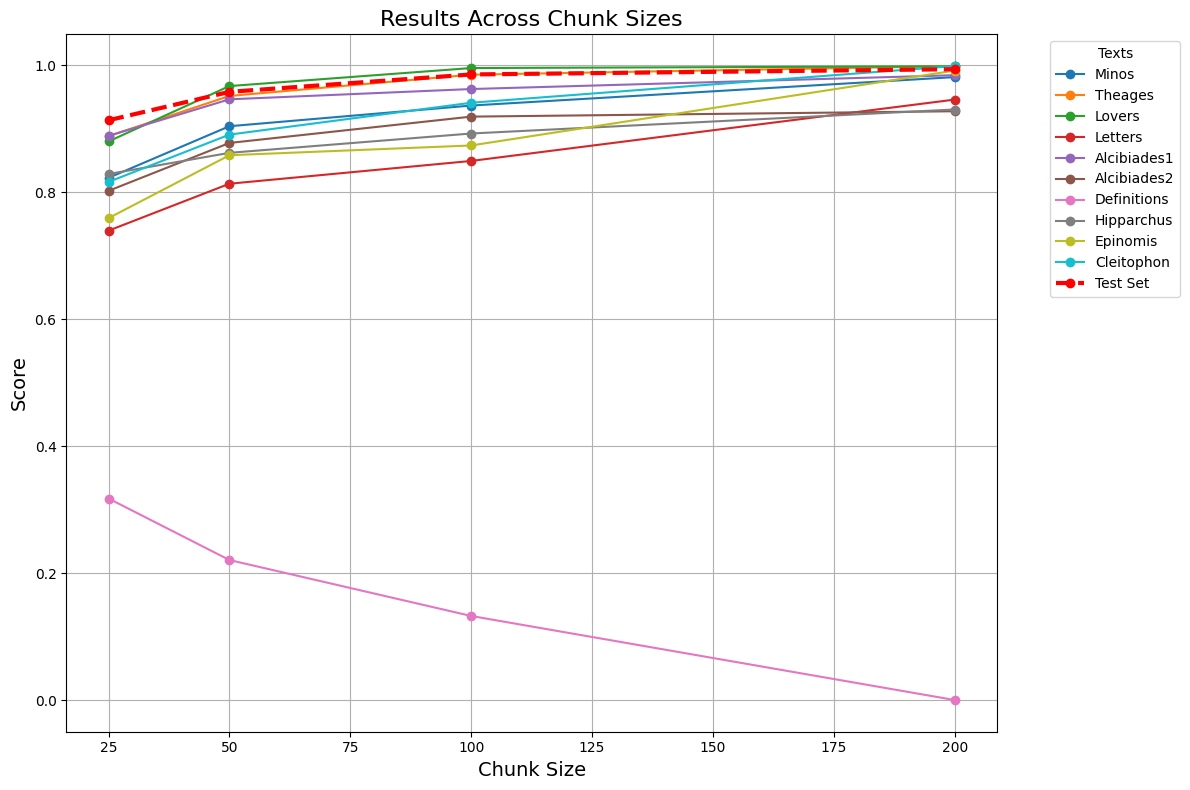

In [171]:
# Convert dictionary to sorted list for easier processing
sorted_data = sorted(tabs.items(), key=lambda x: x[0])
chunk_sizes = [item[0] for item in sorted_data]
text_scores = {text: [] for text in next(iter(tabs.values())).keys()}

# Populate scores for each text
for _, scores in sorted_data:
    for text, score in scores.items():
        text_scores[text].append(score)

# Plot the results
plt.figure(figsize=(12, 8))

for text, scores in text_scores.items():
    if text == "Test Set":
        plt.plot(chunk_sizes, scores, marker='o', label=text, linewidth=3, linestyle='--', color='red')  # Bold red dashed line
    else:
        plt.plot(chunk_sizes, scores, marker='o', label=text)

plt.title("Results Across Chunk Sizes", fontsize=16)
plt.xlabel("Chunk Size", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(title="Texts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Transformer

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, MultiHeadAttention
from tensorflow.keras.models import Model

def positional_encoding(max_position, embedding_dim):
    """
    Generates positional encoding for sequences.
    """
    positions = np.arange(max_position)[:, np.newaxis]
    dims = np.arange(embedding_dim)[np.newaxis, :]

    angles = positions / np.power(10000, (2 * (dims // 2)) / embedding_dim)
    encoding = np.zeros_like(angles)
    encoding[:, 0::2] = np.sin(angles[:, 0::2])
    encoding[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.cast(encoding, dtype=tf.float32)

def transformer_encoder(input_dim, embedding_dim, num_heads, ff_dim, dropout_rate=0.1):
    """
    Builds a Transformer encoder block.
    """
    inputs = Input(shape=(input_dim, embedding_dim))
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(embedding_dim)(ff)
    ff = LayerNormalization(epsilon=1e-6)(ff + attention)

    return Model(inputs, ff, name="TransformerEncoder")

def create_transformer(input_dim, embedding_dim, num_heads, ff_dim, num_classes=1, dropout_rate=0.1):
    """
    Builds a Transformer-based classification model.
    """
    inputs = Input(shape=(input_dim, embedding_dim))

    # Add positional encoding
    position_encodings = positional_encoding(input_dim, embedding_dim)
    x = inputs + position_encodings

    # Transformer encoder block
    x = transformer_encoder(input_dim, embedding_dim, num_heads, ff_dim, dropout_rate)(x)

    # Pooling (reduce sequence to a single vector)
    x = tf.reduce_mean(x, axis=1)

    # Classification head
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)

    return Model(inputs, outputs, name="TransformerModel")

In [78]:
def all_texts_testset_transformer(data_dubia, chunk_size, w2v_model, model):
    """
    Prepares and tests the transformer model on all dubia texts, calculating mean predictions for each text.
    """
    results = {}

    for label, text in data_dubia:
        if label != -1:
            continue  # Process only texts with label -1

        words = text.split()
        
        text_name = words[0]

        text_body = " ".join(words[1:])

        # Generate sliding window chunks
        num_chunks = len(text_body.split()) - chunk_size + 1
        if num_chunks <= 0:
            results[text_name] = None  # No valid chunks
            continue

        text_chunks = [
            text_body.split()[i:i + chunk_size]
            for i in range(1, num_chunks)
        ]

        # Convert chunks into sequences of embeddings
        chunk_embeddings = [
            [
                w2v_model.wv[word] if word in w2v_model.wv else np.zeros(w2v_model.vector_size)
                for word in chunk
            ]
            for chunk in text_chunks
        ]

        if not chunk_embeddings:
            results[text_name] = None  # No valid embeddings
            continue

        # Convert to NumPy array
        X_test = np.array(chunk_embeddings)

        # Get predictions for the embeddings
        predictions = model.predict(X_test, verbose=0)

        # Calculate mean prediction for the text
        mean_score = np.mean(predictions)
        results[text_name] = mean_score

    return results

## Transformer Implementation

In [77]:
chunk_size = 100
percentage = 0.2
X_train, y_train, X_val, y_val, X_test, y_test = lstm_datasets_percentage(data_combined, chunk_size, w2v_model, 0.8, 0.1, 0.1,percentage)

In [79]:
with open(f"transformer_datasets_{percentage}_{chunk_size}.pkl", "wb") as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

In [80]:
with open(f"transformer_datasets_{percentage}_{chunk_size}.pkl", "rb") as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

In [81]:
embedding_dim = w2v_model.vector_size
model = create_transformer(
    input_dim=chunk_size,
    embedding_dim=embedding_dim,
    num_heads=4,
    ff_dim=128,
    num_classes=1,
    dropout_rate=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

633/633 [==============================] - 13s 21ms/step - loss: 0.0803 - accuracy: 0.9691
Test Accuracy: 0.97


In [82]:
results = all_texts_testset_lstm(data_dubia, chunk_size, w2v_model, model)

# Print the results
print("\nMean Predictions for Dubia Texts:")
for text_name, mean_score in results.items():
    if mean_score is not None:
        print(f"{text_name}: {mean_score:.4f}")
    else:
        print(f"{text_name}: No valid chunks")


Mean Predictions for Dubia Texts:
Minos: 0.7562
Theages: 0.8262
Lovers: 0.8636
Letters: 0.5299
Alcibiades1: 0.8932
Alcibiades2: 0.6863
Definitions: 0.0004
Hipparchus: 0.8368
Epinomis: 0.8320
Cleitophon: 0.7033
